# Estimating Value-at-risk using Monte Carlo

VaR reports the worst expected loss – at a given level of confidence – over a certain horizon under normal market conditions. The easiest way to understand it
is by looking at an example. Let's say that the 1-day 95% VaR of our portfolio is $100. This means that 95% of the time (under normal market conditions), we will not lose more than
$100 by holding our portfolio over one day.

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set random seed for reproducibility
np.random.seed(42)

In [9]:
RISKY_ASSETS = ['GOOG', 'META']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

In [10]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

df.head()

[*********************100%***********************]  2 of 2 completed
Downloaded 250 rows of data.


Adj Close                  Close                   High  \
                 GOOG        META       GOOG        META       GOOG   
Date                                                                  
2018-01-02  53.250000  181.419998  53.250000  181.419998  53.347000   
2018-01-03  54.124001  184.669998  54.124001  184.669998  54.314499   
2018-01-04  54.320000  184.330002  54.320000  184.330002  54.678501   
2018-01-05  55.111500  186.850006  55.111500  186.850006  55.212502   
2018-01-08  55.347000  188.279999  55.347000  188.279999  55.563499   

                              Low                   Open              \
                  META       GOOG        META       GOOG        META   
Date                                                                   
2018-01-02  181.580002  52.261501  177.550003  52.417000  177.679993   
2018-01-03  184.779999  53.160500  181.330002  53.215500  181.880005   
2018-01-04  186.210007  54.200100  184.100006  54.400002  184.899994   
2018-01-05  186.899994  54.599998  184.929993  54.700001  185.589996   
2018-01-08  188.899994  55.081001  186.330002  55.111500  187.199997   

              Volume            
                GOOG      META  
Date                            
2018-01-02  24752000  18151900  
2018-01-03  28604000  16886600  
2018-01-04  20092000  13880900  
2018-01-05  25582000  13574500  
2018-01-08  20952000  17994700

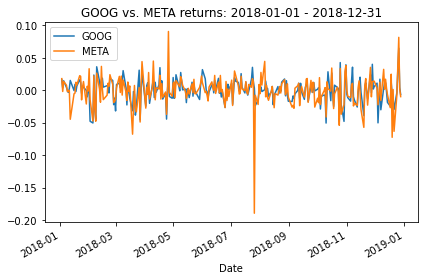

Correlation between returns: 0.62


In [11]:
# Calculate daily returns

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

In [12]:
# Calculate covariance matrix

cov_mat = returns.cov()
cov_mat

,GOOG,META
GOOG,0.000315,0.000265
META,0.000265,0.000575


In [13]:
# Perform the Cholesky decomposition of the covariance matrix

chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.0177591 , 0.        ],
       [0.0149283 , 0.01876435]])

In [14]:
# Draw correlated random numbers from Standard Normal distribution

rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

In [15]:
# Define metrics used for simulations

r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [16]:
# Calculate the terminal price of the considered stocks

S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

In [17]:
# Calculate the terminal portfolio value and calculate the portfolio returns

P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [18]:
# Calculate VaR

P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 2.44$
1-day VaR with 99.9% confidence: 2.18$
1-day VaR with 99.0% confidence: 1.86$


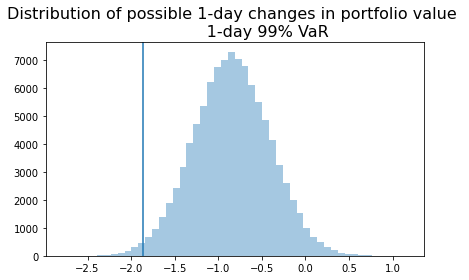

In [20]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()
plt.show()

In [21]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 1.56$, and the accompanying Expected Shortfall is 1.75$.
